In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor  #for VIF

## Read CSV in pandas dataframe

In [3]:
titanic=pd.read_csv("titanic.csv")
titanic.head()

#titanic.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


VARIABLE DESCRIPTIONS
Survived - Survival (0 = No; 1 = Yes)
Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
Name - Name
Sex - Sex
Age - Age
SibSp - Number of Siblings/Spouses Aboard
Parch - Number of Parents/Children Aboard
Ticket - Ticket Number
Fare - Passenger Fare (British pound)
Cabin - Cabin
Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

## Count number of survivors

Since we are building a model to predict survival of passangers from the Titanic, our target is going to be "Survived" variable from the titanic dataframe. To make sure that it's a binary variable, let's use Seaborn's countplot() function.

<Axes: xlabel='Survived', ylabel='count'>

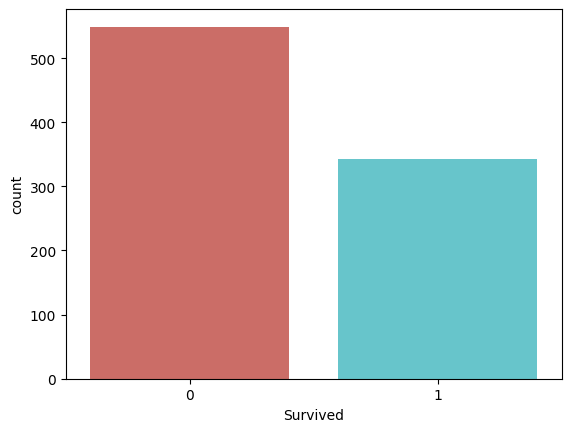

In [7]:
sb.countplot(x='Survived', hue='Survived',data=titanic, palette='hls', legend=False)

#sb.countplot(x='Survived',data=titanic, palette='hls')           #deprecated. set x to hue

## Check Missing Values

In [9]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Cleaning dataframe

We can drop irrelevant variable. We should at least keep the following:

Survived - This variable is obviously relevant.
Pclass - Does a passenger's class on the boat affect their survivability?
Sex - Could a passenger's gender impact their survival rate?
Age - Does a person's age impact their survival rate?
SibSp - Does the number of relatives on the boat (that are siblings or a spouse) affect a person survivability? Probability
Parch - Does the number of relatives on the boat (that are children or parents) affect a person survivability? Probability
Fare - Does the fare a person paid effect his survivability? Maybe - let's keep it.
Embarked - Does a person's point of embarkation matter? It depends on how the boat was filled... Let's keep it.
What about a person's name, ticket number, and passenger ID number? They're irrelavant for predicting survivability. And as you recall, the cabin variable is almost all missing values, so we can just drop all of these.

### Drop irrelevant Columns

In [14]:
#PassengerId - Irrelevant
#Ticket      - Irrelevant
#Name        - Irrelevant
#Cabin       - 687 of 891 rows missing

In [15]:
titanic_data = titanic.drop(columns=['PassengerId','Name','Ticket','Cabin'])
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Fill in values for AGE

**Step 1: Find mean age based on passenger class Pclass**

<Axes: xlabel='Pclass', ylabel='Age'>

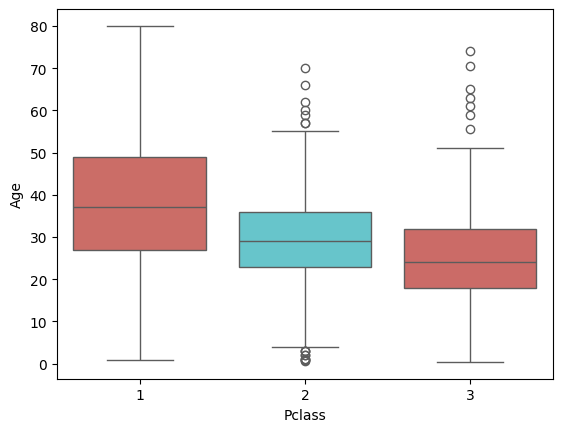

In [18]:
sb.boxplot(x='Pclass', hue='Pclass', y='Age', data=titanic_data, palette='hls', legend=False)

#sb.boxplot(x='Pclass', y='Age', data=titanic_data, palette='hls')           #deprecated

Speaking roughly, we could say that the younger a passenger is, the more likely it is for them to be in 3rd class. The older a passenger is, the more likely it is for them to be in 1st class. So there is a loose relationship between these variables. We can write a function that approximates a passengers age, based on their class. From the box plot, it looks like the average age of 1st class passengers is about 37, 2nd class passengers is 29, and 3rd class pasengers is 24.

So let's write a function that finds each null value in the Age variable, and for each null, checks the value of the Pclass and assigns an age value according to the average age of passengers in that class.

**Step 2: Create function for replacing null (Age) with mean values**

In [21]:
def age_approx(cols):
    Age = cols.iloc[0]                 #Age = cols[0]         deprecated
    Pclass = cols.iloc[1]              #Pclass = cols[1]      deprecated

    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

**Step 3: Create new dataframe and fill in mean age based on passenger class Pclass**

In [23]:
titanic_data['Age'] = titanic_data[['Age', 'Pclass']].apply(age_approx, axis=1)
# Apply the age_approx function to each row (axis=1)

titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

### Delete rows with null values

There are 2 null values in the embarked variable. We can drop those 2 records without lossing too much important information from our dataset

In [26]:
titanic_data.dropna(inplace=True)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [27]:
titanic_data.info()

#2 null rows removed. 891 to 889

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


## Reformat object variables into numeric variables

**Step 1: 'Sex' object to numerical variable**

In [30]:
Sex_num = pd.get_dummies(titanic_data['Sex'], drop_first=True, dtype=int)
Sex_num.head()

#pd.get_dummies(...): This function converts categorical variable(s) into dummy/indicator variables.
#drop_first=True: 
#This parameter drops the first category to avoid multicollinearity. For example, if the 'Sex' column contains 'male' and 'female', 
#dropping the first category ('female') means you only get a column indicating whether the entry is 'male' (with 1 for 'male' and 0 for 'female').
#dtype=int: This ensures that the resulting dummy variables are of integer type.

,male
0,1
1,0
2,0
3,0
4,1


**Step 2: 'Embarked' object to numerical variable**

In [32]:
Embarked_num = pd.get_dummies(titanic_data['Embarked'], drop_first=True, dtype=int)
Embarked_num.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [33]:
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


**Step 3: Drop 'Sex' and 'Embarked' columns**

In [35]:
titanic_data.drop(['Sex', 'Embarked'],axis=1,inplace=True)
titanic_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


**Step 3: Create new dataframe. Add new 'Sex_num' and 'Embarked_num' columns**

In [37]:
titanic_dmy = pd.concat([titanic_data,Sex_num,Embarked_num],axis=1)
titanic_dmy.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


## Check for correlation among features

**Method 1: Heatmap**

<Axes: >

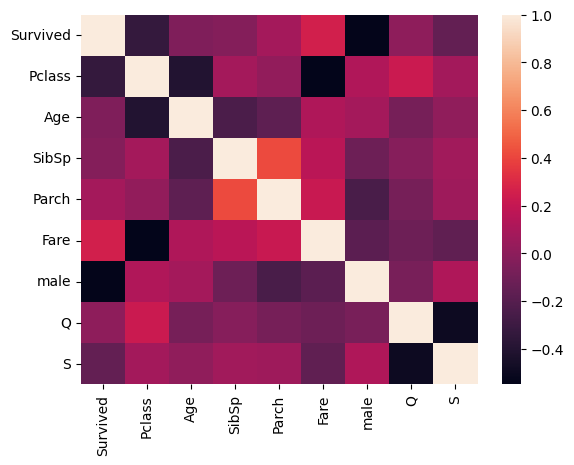

In [40]:
sb.heatmap(titanic_dmy.corr())

**Method 2: VIF**

In [42]:
# compute the vif for all given features
def compute_vif(considered_features):

    X = titanic_dmy.loc[:,considered_features]         #X = df[considered_features]    #deprecated

    # the calculation of variance inflation requires a constant
    X['intercept'] = 1

    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [43]:
titanic_dmy.dtypes

Survived      int64
Pclass        int64
Age         float64
SibSp         int64
Parch         int64
Fare        float64
male          int32
Q             int32
S             int32
dtype: object

In [44]:
# Look at VIF for all the numeric
considered_features = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'male', 'Q', 'S']

# compute vif
compute_vif(considered_features).sort_values('VIF', ascending=False)

,Variable,VIF
1,Pclass,2.011815
0,Survived,1.659733
5,Fare,1.649378
6,male,1.531224
7,Q,1.489370
8,S,1.472266
2,Age,1.345501
4,Parch,1.332523
3,SibSp,1.303948


## Dropping more irrevelant Columns

In [46]:
# fare is dependant on class so should be dropped
titanic_dmy.drop(['Fare', 'Pclass'],axis=1,inplace=True)
titanic_dmy.head()

,Survived,Age,SibSp,Parch,male,Q,S
0,0,22.0,1,0,1,0,1
1,1,38.0,1,0,0,0,0
2,1,26.0,0,0,0,0,1
3,1,35.0,1,0,0,0,1
4,0,35.0,0,0,1,0,1


## Create train and test sets

In [48]:
X = titanic_dmy.iloc[:,1:].values
y=titanic_dmy['Survived'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=20)

## Training Model

In [50]:
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

LogisticRegression()

In [51]:
y_pred = LogReg.predict(X_test)

In [52]:
y_pred[:10]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0], dtype=int64)

In [53]:
y_test[:10]

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 1], dtype=int64)

## Confusion Matrix

In [55]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[48,  8],
       [ 6, 27]], dtype=int64)

## Classification report

In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87        56
           1       0.77      0.82      0.79        33

    accuracy                           0.84        89
   macro avg       0.83      0.84      0.83        89
weighted avg       0.85      0.84      0.84        89

